# Project: Wrangle and Analyze Data - WeRateDogs
Author: Wei Chong Ong

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a>
    <ul><li><a href="#gathering">Gathering</a>
        <ul><li><a href="#manually">Download file manually</a>
        <li><a href="#programmatically">Download file programmatically using Requests library</a>
        <li><a href="#api">Gather additional data via the Twitter API</a>
        </ul>
        </li>
        <li><a href="#assessing">Assessing</a>
        <li><a href="#cleaning">Cleaning</a>
    </ul>
    </li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
</ul>

<a id='intro' ></a>
# Introduction
In this notebook, I will first gather WeRateDogs Twitter data from different sources in different file formats using three different gathering methods. Each piece of data will be then imported into a separate pandas DataFrame. After that, I will assess the quality and tidiness of the data visually and programmatically. Each issue will be documented. Next, each of the cleaning processes will be divided into `define`, `code` and `test` steps to make the cleaning process as clear as possible. By the end of the data wrangling, a tidy master dataset with all pieces of gathered data will be created and stored as a csv file. The master dataset will then be used for exploratory data analysis to produce insights about WeRateDog.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import os
import tweepy
import json
import time
import re
import statsmodels.api as sm

<a id='wrangling' ></a>
# Data Wrangling
Data wrangling consists of three main parts:
- Gathering data
- Assessing data
- Cleaning data

<a id='gathering' ></a>
## Gathering

<a id='manually'></a>
### 1. Download data manually
The WeRateDogs Twitter archive is given as twitter-archive-enhanced.csv. It can be downloaded manually.

In [2]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
pd.set_option('max_colwidth', None)
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


<a id='programmatically'></a>
### 2. Download data programmatically using Requests library
Every image in the WeRateDogs Twitter archive is ran through a neural network that can classify breeds of dogs. Creating this neural network is one of the projects in Udacity's Data Scientist Nanodegree, Machine Learning Engineer Nanodegree and Artificial Intelligence Nanodegree programs. The file that contains the results is hosted on Udacity's servers. 

In this project, the results are used for further analysis and visualization. This file is downloaded programmatically using the Requests library and the url given by Udacity to access to its servers.

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

200 being the HTTP status code for the request has succeeded

In [4]:
# Open this file in WB mode, Write Binary, because response content is in bytes and not text
# Write the response content into the file
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [5]:
# Read the tsv file into a dataframe
df_image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Results:** a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). 

- tweet_id is the part of the `expanded_urls` after "status/" in the `df_twitter_archive` table
- p1 is the algorithm's #1 prediction for the image in the tweet
- p1_conf is how confident the algorithm is in its #1 prediction 
- p1_dog is whether or not the #1 prediction is a breed of dog
- p2 is the algorithm's second most likely prediction
- p2_conf is how confident the algorithm is in its #2 prediction
- p2_dog is whether or not the #2 prediction is a breed of dog
- etc.

<a id='api'></a>
### 3. Gather additional data via the Twitter API

Python's Tweepy library is used to query Twitter's API for each tweet's JSON data included in the WeRateDogs Twitter archive, as Tweet data is stored in JSON format by Twitter. This data includes retweet count, favorite count, etc. Each tweet's entire set of JSON data is then stored in a file called `tweet_json.txt`. 

#### [Creating Twitter's API object](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object)
- The Twitter API requires users to be authorized to use it. Before running API querying code, own Twitter application needs to be set up. 

- Twitter's API has a rate limit. Rate limiting is used to control the rate of traffic sent or received by a server. As per Twitter's rate limiting info page: Rate limits are divided into 15 minute intervals. `wait_on_rate_limit` and `wait_on_rate_limit_notify` parameters are set to `True` in the **`tweepy.api`** class to continue the querying and get notification while waiting for the rate limit.

In [6]:
consumer_key = 'CONSUMER KEY'
consumer_secret = 'CONSUMER SECRET'
access_token = 'ACCESS TOKEN'
access_secret = 'ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### [Getting tweet JSON data via tweet ID using Tweepy](https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id)
- Since it takes a while to query all of the tweet IDs in the WeRateDogs Twitter archive, a [code timer](https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python) is used for sanity reasons. 
- [Try-except blocks](https://wiki.python.org/moin/HandlingExceptions) is used to attempt to query Twitter's API for tweet status of each tweet_id. If the attempt fails and an error is encountered, the tweet_id and the error is printed out.
- The tweet_mode parameter is set to `extended` in the `get_status` call. When using [extended mode](http://docs.tweepy.org/en/latest/extended_tweets.html), the text attribute of Status objects returned by tweepy.API methods is replaced by a full_text attribute, which contains the entire untruncated text of the Tweet. 
- After querying each tweet ID, each tweet's JSON data is written to its own line.

In [7]:
# Code timer starts
start = time.time()
tweet_id = list(df_twitter_archive['tweet_id'])

with open('tweet_json.txt', 'w') as file:
    for tweet in tweet_id:
        try:
            tweet_status = api.get_status(tweet, tweet_mode='extended')._json
            json.dump(tweet_status, file)
            file.write('\n')

        except Exception as e:
            print(str(tweet) + ": " + str(e.args[0][0]))

# Code timer ends
end = time.time()
print('Running time: {} minutes'.format((end - start)/60))

888202515573088257: {'code': 144, 'message': 'No status found with that ID.'}
873697596434513921: {'code': 144, 'message': 'No status found with that ID.'}
872668790621863937: {'code': 144, 'message': 'No status found with that ID.'}
872261713294495745: {'code': 144, 'message': 'No status found with that ID.'}
869988702071779329: {'code': 144, 'message': 'No status found with that ID.'}
866816280283807744: {'code': 144, 'message': 'No status found with that ID.'}
861769973181624320: {'code': 144, 'message': 'No status found with that ID.'}
856602993587888130: {'code': 144, 'message': 'No status found with that ID.'}
851953902622658560: {'code': 144, 'message': 'No status found with that ID.'}
845459076796616705: {'code': 144, 'message': 'No status found with that ID.'}
844704788403113984: {'code': 144, 'message': 'No status found with that ID.'}
842892208864923648: {'code': 144, 'message': 'No status found with that ID.'}
837366284874571778: {'code': 144, 'message': 'No status found wi

Rate limit reached. Sleeping for: 647


758740312047005698: F
754011816964026368: {'code': 144, 'message': 'No status found with that ID.'}
680055455951884288: {'code': 144, 'message': 'No status found with that ID.'}


Rate limit reached. Sleeping for: 641


676957860086095872: F
Running time: 34.22303281625112 minutes


#### [Read Twitter JSON from a txt file](https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/)
- Read the .txt file that contains the json objects ([newline delimited json](https://medium.com/@kandros/newline-delimited-json-is-awesome-8f6259ed4b4b)) line by line into a list of dictionaries.
- This list of dictionaries is then used to create a pandas DataFrame with tweet ID, retweet count, and favorite count.

In [8]:
# Import the json objects from the .txt file and read it line by line into a list of dictionaries
with open('tweet_json.txt') as file:
    status = []
    for line in file:
        status.append(json.loads(line))

In [9]:
# Extract tweet_id, retweet_count & favorite_count from the json object and store them into a list of dictionaries
api_data = []
for i in range(len(status)):
    api_data.append({'tweet_id': status[i]['id'],
                      'retweet_count': status[i]['retweet_count'],
                      'favorite_count': status[i]['favorite_count']})

In [10]:
# Create dataframe form the list of dictionaries
df_api = pd.DataFrame(api_data, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

#### Merge all three dataframes to create a master dataframe

In [11]:
df_master = pd.merge(df_twitter_archive, df_api, how = 'left', on = 'tweet_id')
df_master = pd.merge(df_master, df_image_predictions, how = 'left', on = 'tweet_id')

<a id='assessing' ></a>
## Assessing
Assess the data visually and programmatically for quality and tidiness issues. In this project, I use only original ratings (no retweets) that have images. In this dataset, not all are dog ratings and some are retweets.

### Assess visually

In [12]:
pd.set_option('display.max_columns', None)
df_master.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1063,741067306818797568,NaN,NaN,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741067306818797568/photo/1,12,10,just,doggo,None,pupper,None,3006.0,9312.0,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1.0,golden_retriever,0.843799,True,Labrador_retriever,0.052956,True,kelpie,0.035711,True
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,470.0,1675.0,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1.0,kuvasz,0.438627,True,Samoyed,0.111622,True,Great_Pyrenees,0.064061,True
2045,671528761649688577,NaN,NaN,2015-12-01 03:18:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He's in the middle of a serious conversation and is trying unbelievably hard not to laugh. 10/10 https://t.co/HwiLcDPaCi,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671528761649688577/photo/1,10,10,Jax,None,None,None,None,239.0,791.0,https://pbs.twimg.com/media/CVG_2I-WIAASKSS.jpg,1.0,Doberman,0.782626,True,black-and-tan_coonhound,0.109678,True,Gordon_setter,0.052110,True
1327,705975130514706432,NaN,NaN,2016-03-05 04:36:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Adele. Her tongue flies out of her mouth at random. It's a debilitating illness. 10/10 stay strong pupper https://t.co/cfn81n3FLO,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/705975130514706432/photo/1,https://twitter.com/dog_rates/status/705975130514706432/photo/1",10,10,Adele,None,None,pupper,None,709.0,3024.0,https://pbs.twimg.com/media/CcwgjmuXIAEQoSd.jpg,1.0,Staffordshire_bullterrier,0.587764,True,American_Staffordshire_terrier,0.281429,True,bull_mastiff,0.094798,True
1305,707387676719185920,NaN,NaN,2016-03-09 02:08:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Clarkus. He's a Skinny Eastern Worcestershire. Can tie own shoes (impressive af) 10/10 would put on track team https://t.co/XP5o7zGn0E,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707387676719185920/photo/1,10,10,Clarkus,None,None,None,None,1244.0,3405.0,https://pbs.twimg.com/media/CdElVm7XEAADP6o.jpg,1.0,Chihuahua,0.888468,True,Italian_greyhound,0.088635,True,toy_terrier,0.015938,True


> - Two variables (text and url) form `text` column
> - One variable forms four columns (dog "stage" - doggo, floofer, pupper, puppo)
> - Unnecessary HTML code in the source column

### Assess programmatically

In [13]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

> - Erroneous datatypes: tweet_id, in_reply_to_status_id, in_reply_to_user_i, timestamp, retweet_count, favorite_count
> - Missing retweet and favorite counts

In [14]:
df_master['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

> Most of the the rating numerators are greater than the denominators (10). This unique rating system is a big part of the popularity of WeRateDogs. However, there are some much smaller or larger than 10 and it could be errors.

In [15]:
df_master[df_master['rating_numerator']==1][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
605,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1,10
1446,After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me,1,10
1869,What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0,1,10
1940,The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,1,10
2038,After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,1,10
2091,Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,1,10
2261,Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,1,10
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2
2338,Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,1,10


> As we can see in the row with index 2335, the rating is wrong. It should be 9/10 instead of 1/2

In [16]:
df_master[df_master['rating_numerator']==1776][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10


> This is not an error, but it is definitely an outlier. There are some other outliers as well but I will not assess them one by one for now because they could be retweets or replies without images. I will assess them later after removing all the invalid records.

In [17]:
df_master['rating_denominator'].value_counts() 

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

> There are only a few records with the denominator not equal to 10. I will remove them after confirming every single one of them are not due to extraction errors.

In [18]:
df_master[df_master['rating_denominator']==50][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50


> - The rating got extracted wrongly when there are two rating regular expression pattern in the text (e.g. index 1202 and 2335)  
> - Incorrect values in the rating_denominator column (The denominator should be always equal to 10)

In [19]:
df_master['tweet_id'].duplicated().sum()

0

> No duplicated tweet_id

In [20]:
# Retweets (tweet_id changes after retweeted. That means two different tweet_id with the same picture)
df_master['jpg_url'].duplicated().sum()

346

> There are duplicates in jpg_url due to retweets

In [21]:
len(df_master[df_master['jpg_url'].isnull() & ~df_master['expanded_urls'].isnull()])

222

> Missing predictions: There are 222 rows with images but no prediction results.

In [22]:
df_master[df_master['expanded_urls'].isnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,4.0,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None,7.0,116.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None,10.0,293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None,3.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None,88.0,2063.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Records that have no images (no url included in the text as well as no expanded_urls), mostly due to replies. That means most of the replies do not have images for the neural network to make dog breed prediction. If a reply has an image, it will be a new tweet_id, new image and new rating. Original image and the 'reply image' will be both in the dataset. 

In [23]:
for text in list(df_master['text']):
    if 'Pipsy' in text:
        print(text)

Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen
RT @dog_rates: This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://…
I found a forest Pipsy. 12/10 https://t.co/mIQ1KoVsmU
This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://t.co/h9R0EwKd9X


> There are two replies (with new images) and one retweet of the original Pipsy tweet

In [24]:
# Find out all the invalid names by assuming that all the first letter of the correct names is a capital letter
df_master[df_master['name'].apply(lambda x: x[0].islower())]['name'].value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
getting          2
not              2
mad              2
actually         2
light            1
officially       1
life             1
this             1
old              1
his              1
space            1
such             1
my               1
infuriating      1
unacceptable     1
by               1
incredibly       1
all              1
Name: name, dtype: int64

> Invalid dog names

In [25]:
df_master['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

> Unnecessary HTML code in the source column

### Data Assessing Summary

#### Quality - Completeness
- Irrelevant records (retweets) and corresponding columns (Duplicates in jpg_url column are due to retweets)
- Missing prediction results
- Missing retweet and favorite counts

#### Quality - Validity, Accuracy, Consistency
- Invalid names in the name column
- Erroneous datatypes (tweet_id is a int not a string, timestamp is a string not datetime, retweet count, favorite count and img_num are float not integer)
- Sometimes the rating got extracted wrongly when there are two rating expressions in the text (e.g. index 1202 and 2335)
- Very large of value of rating_numerator (outliers)
- Incorrect values in the rating_denominator column (The denominator should be always equal to 10)

#### Tidiness
- Two variable form text column and they should be split into text and url
- Multiple prediction columns (p1, p2, p3)
- One variable forms four columns (dog "stage" - doggo, floofer, pupper, puppo)
- Unnecessary HTML code in the source column

<a id='cleaning' ></a>
## Cleaning

### Steps

<ol>
  <p><b>Quality - Completeness</b></p>
  <li>Remove retweets records</li>
  <li>Remove records without predictions</li>
  <li>Remove records without retweet and favorite counts</li>
  <p><b>Tidiness</b></p>
  <li>Combine the doggo, floofer, pupper, puppo columns to a dog "stage" column, convert to category datatype and drop the corresponding columns</li>
  <li>Reduce the prediction columns into breed and conf column</li>
  <li>Extract all shortened URLs from text column using regular expression, create new column for the shortened twitter url and replace this url in the text column with empty string</li>
  <li>Extract the name of the source from the HTML code in the source column using regular expression</li>
  <p><b>Quality - Validity, Accuracy, Consistency</b></p>
  <li>Replace the invalid names with None</li>
  <li>Convert the erroneous datatypes to the correct datatypes</li>
  <li>Replace the ratings with correct ratings by extracting from the text column and remove outliers</li>
  <li>Remove the records that the rating_denominator is not equal to 10</li>
</ol>

### Quality - Completeness

In [26]:
df_master_clean = df_master.copy()

#### Define (#1)
Remove retweets records

#### Code (#1)

In [27]:
df_master_clean = df_master_clean[df_master_clean['retweeted_status_id'].isnull()]

#### Test (#1)

In [28]:
len(df_master_clean[~df_master_clean['retweeted_status_id'].isnull()])

0

In [29]:
df_master_clean = df_master_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 
                                        'retweeted_status_timestamp'], axis=1)

#### Define  (#2)
Remove records without predictions

#### Code (#2)

In [30]:
df_master_clean = df_master_clean[~df_master_clean['jpg_url'].isnull()]

#### Test (#2)

In [31]:
len(df_master_clean[df_master_clean['jpg_url'].isnull()])

0

#### Define  (#3)
Remove records without retweet and favorite counts

#### Code (#3)

In [32]:
df_master_clean = df_master_clean[~df_master_clean['retweet_count'].isnull() | ~df_master_clean['favorite_count'].isnull()]

#### Test (#3)

In [33]:
len(df_master_clean[df_master_clean['retweet_count'].isnull() | df_master_clean['favorite_count'].isnull()])

0

In [34]:
# Check if there are still duplicated images after dropping the retweets and all the missing jpg_url
sum(df_master_clean['jpg_url'].duplicated())

0

### Tidiness

#### Define  (#4)
Combine the doggo, floofer, pupper, puppo columns to a dog "stage" column, convert to category datatype and drop the corresponding columns

#### Code (#4)

In [35]:
# Replace 'None' with empty string ''
for stage in ['doggo', 'floofer', 'pupper', 'puppo']:
    df_master_clean[stage].replace('None', '', inplace = True)

# Concatenate the stage name into one column
df_master_clean['dog_stage'] = df_master_clean['doggo'].map(str) + df_master_clean['floofer'].map(str) + df_master_clean['pupper'].map(str) + df_master_clean['puppo'].map(str)

In [36]:
# Replace empty string '' with np.nan
df_master_clean['dog_stage'].replace('', np.nan, inplace = True)

# Count the number of each stage name
df_master_clean['dog_stage'].value_counts()

pupper          203
doggo            62
puppo            22
doggopupper       9
floofer           7
doggopuppo        1
doggofloofer      1
Name: dog_stage, dtype: int64

> There are some records with two stage names. I will confirm the stage of the dog by looking the image one by one, because sometimes the text could be misleading.

In [37]:
df_master_clean.query("dog_stage in ['doggopupper', 'doggopuppo', 'doggofloofer']")[['text', 'doggo', 'floofer', 'pupper', 'puppo', 'dog_stage']]

,text,doggo,floofer,pupper,puppo,dog_stage
191,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggo,,,puppo,doggopuppo
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggo,floofer,,,doggofloofer
460,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",doggo,,pupper,,doggopupper
531,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggo,,pupper,,doggopupper
565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggo,,pupper,,doggopupper
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggo,,pupper,,doggopupper
705,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,doggo,,pupper,,doggopupper
889,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggo,,pupper,,doggopupper
956,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,doggo,,pupper,,doggopupper
1063,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggo,,pupper,,doggopupper


> Real dog stage for each case:
- 191: puppo
- 200: puppo
- 460: pupper
- 531: two dogs
- 565: two dogs
- 575: pupper
- 705: it's a hedgehog
- 889: two dogs
- 956: doggo
- 1063: two dogs
- 1113: two dogs (same dogs as 565, but with different image: this record is a reply)  

> Those that cannot be identified as one type of dog stage will be np.nan

In [38]:
df_master_clean.loc[191, 'dog_stage'] = 'puppo'
df_master_clean.loc[200, 'dog_stage'] = 'puppo'
df_master_clean.loc[460, 'dog_stage'] = 'pupper'
df_master_clean.loc[531, 'dog_stage'] = np.nan
df_master_clean.loc[565, 'dog_stage'] = np.nan
df_master_clean.loc[575, 'dog_stage'] = 'pupper'
df_master_clean.loc[705, 'dog_stage'] = np.nan
df_master_clean.loc[889, 'dog_stage'] = np.nan
df_master_clean.loc[956, 'dog_stage'] = 'doggo'
df_master_clean.loc[1063, 'dog_stage'] = np.nan
df_master_clean.loc[1113, 'dog_stage'] = np.nan

In [39]:
# Convert dog_stage to category datatype
df_master_clean['dog_stage'] = df_master_clean['dog_stage'].astype('category')

# Drop 'doggo', 'floofer', 'pupper', 'puppo' columns
df_master_clean = df_master_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

#### Test (#4)

In [40]:
df_master_clean['dog_stage'].value_counts()

pupper     205
doggo       63
puppo       24
floofer      7
Name: dog_stage, dtype: int64

#### Define  (#5)
Reduce the prediction columns into breed and conf column

#### Code (#5)

In [41]:
def get_dog_breed(x):
    if x[0] == True:
        return x[1]
    elif x[2] == True:
        return x[3]
    elif x[4] == True:
        return x[5]
    else:
        return np.nan

In [42]:
df_master_clean['breed'] = df_master_clean[['p1_dog', 'p1', 'p2_dog', 'p2', 'p3_dog', 'p3']].apply(get_dog_breed, axis = 1)
df_master_clean['conf'] = df_master_clean[['p1_dog', 'p1_conf', 'p2_dog', 'p2_conf', 'p3_dog', 'p3_conf']].apply(get_dog_breed, axis = 1)

#### Test (#5)

In [43]:
df_master_clean.iloc[:,-12:].sample(5)

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,breed,conf
1344,Chihuahua,0.376541,True,Siamese_cat,0.098057,False,Labrador_retriever,0.085211,True,NaN,Chihuahua,0.376541
2010,Irish_terrier,0.413173,True,Airedale,0.335616,True,toy_poodle,0.027952,True,NaN,Irish_terrier,0.413173
879,axolotl,0.132695,False,killer_whale,0.131113,False,sea_lion,0.069652,False,NaN,NaN,NaN
1104,Walker_hound,0.413535,True,beagle,0.233891,True,English_foxhound,0.164943,True,pupper,Walker_hound,0.413535
1038,Samoyed,0.960543,True,Pomeranian,0.012192,True,white_wolf,0.004753,False,NaN,Samoyed,0.960543


#### Define  (#6)
[Extract all shortened URLs from text column using re.findall() function](https://stackoverflow.com/questions/45835591/how-to-extract-or-grab-all-shortened-urls-from-a-tweet)  and [regular expression](https://regexone.com), create new column for the shortened twitter url and replace this url in the text column with empty string.   

#### Code (#6)

In [44]:
# Records with two or more than two urls in the text
mask = df_master_clean['text'].map(lambda s: re.findall('(https?://t\.co/\S+)', s)).str.len() > 1
df_master_clean[mask][['tweet_id', 'text']].head()

,tweet_id,text
6,890971913173991426,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl
27,886736880519319552,"This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff https://t.co/ISvKOSkd5b"
75,878281511006478336,"Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY https://t.co/lUiQH219v6"
98,873213775632977920,This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ
114,870656317836468226,This is Cody. He zoomed too aggressively and tore his ACL. Happens to the best of us. Still 13/10\n\nHelp Cody here: https://t.co/4hxnDOt1CV https://t.co/42ryYRQ2Q4


> As we can see here, there are some records with two different urls in the text. I will leave the first url in the text column because it is an external url attached by the user whereas the second url will be put in the shortened_urls column because this is the Twitter post url.

In [45]:
# Insert the second url into the shortened_urls column
df_master_clean['shortened_urls'] = df_master_clean['text'].map(lambda s: re.findall('(https?://t\.co/\S+)', s)[-1])

> Replace the second url with empty string using [re.sub](https://docs.python.org/3/library/re.html#re.sub) to create a text column that consists only text and if applicable, as well as the external url that posted by the user.  

In [46]:
df_master_clean['text'] = df_master_clean['text'].map(lambda s: re.sub(re.findall('(https?://t\.co/\S+)', s)[-1], '', s))

> Since we have now all the urls needed, I will drop the expanded_urls column to make the dataframe looks cleaner.

In [47]:
df_master_clean = df_master_clean.drop('expanded_urls', axis=1)

#### Test (#6)

In [48]:
df_master_clean.loc[[6, 27, 75], ['text', 'shortened_urls']]

,text,shortened_urls
6,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H,https://t.co/tVJBRMnhxl
27,"This is Mingus. He's a wonderful father to his smol pup. Confirmed 13/10, but he needs your help\n\nhttps://t.co/bVi0Yr4Cff",https://t.co/ISvKOSkd5b
75,"Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps://t.co/245xJJElsY",https://t.co/lUiQH219v6


#### Define (#7)
Split the source and extract the name of the source using [regex pattern r'<|>'](https://stackoverflow.com/questions/57297369/i-want-to-extract-a-particular-pattern-from-a-content-string-a-href-http-t)

#### Code (#7)

In [49]:
df_master_clean['source'] = df_master_clean['source'].str.split(r'<|>').str[2]

#### Test(#7)

In [50]:
df_master_clean['source'].value_counts()

Twitter for iPhone    1947
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

#### Define (#8)
Replace the invalid names with None

#### Code (#8)

In [51]:
# Assume that all the first letter of the correct names is a capital letter
invalid_name = list(df_master_clean[df_master_clean['name'].apply(lambda x: x[0].islower())]['name'].unique())
invalid_name.append('None')

In [52]:
invalid_name

['such',
 'a',
 'quite',
 'one',
 'incredibly',
 'very',
 'my',
 'not',
 'his',
 'an',
 'just',
 'getting',
 'this',
 'unacceptable',
 'all',
 'infuriating',
 'the',
 'actually',
 'by',
 'officially',
 'light',
 'space',
 'None']

In [53]:
df_master_clean['name'] = df_master_clean['name'].apply(lambda x: None if x in invalid_name else x)

#### Test (#8)

In [54]:
# Compare intersection of two lists
a = list(df_master_clean['name'].unique())
b = invalid_name
set(a).intersection(b)

set()

#### Define (#9)
Convert the erroneous datatypes to the correct datatypes
- tweet_id, in_reply_to_status_id and in_reply_to_user_id from int to string, 
- timestamp from string to datetime, 
- retweet count, favorite count and img_num from float to integer

#### Code (#9)

In [55]:
df_master_clean['tweet_id'] = df_master_clean['tweet_id'].astype(str)
df_master_clean['in_reply_to_status_id'] = df_master_clean['in_reply_to_status_id'].astype(str)
df_master_clean['in_reply_to_user_id'] = df_master_clean['in_reply_to_user_id'].astype(str)
df_master_clean['timestamp'] = pd.to_datetime(df_master_clean['timestamp'])
df_master_clean['retweet_count'] = df_master_clean['retweet_count'].astype(int)
df_master_clean['favorite_count'] = df_master_clean['favorite_count'].astype(int)
df_master_clean['img_num'] = df_master_clean['img_num'].astype(int)

#### Test (#9)

In [56]:
df_master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 2355
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               1985 non-null   object             
 1   in_reply_to_status_id  1985 non-null   object             
 2   in_reply_to_user_id    1985 non-null   object             
 3   timestamp              1985 non-null   datetime64[ns, UTC]
 4   source                 1985 non-null   object             
 5   text                   1985 non-null   object             
 6   rating_numerator       1985 non-null   int64              
 7   rating_denominator     1985 non-null   int64              
 8   name                   1342 non-null   object             
 9   retweet_count          1985 non-null   int64              
 10  favorite_count         1985 non-null   int64              
 11  jpg_url                1985 non-null   object           

#### Define (#10)
Replace the ratings by extracting the correct ratings from the text column and remove outliers.
- 10.1 Ratings were wrongly extracted due to decimal places
- 10.2 Records with two or more than two ratings in the text column
- 10.3 Records that having very large of value of numerator

#### Code (#10.1)

In [57]:
# Extract ratings from the text column (Note that there might be not only integer but float as well)
pattern = '(\d+(\.\d+)?\/\d+(\.\d+)?)'
rating = df_master_clean['text'].str.extract(pattern)[0].str.split('/', expand = True)
df_master_clean['extract_numerator'] = rating[0]
df_master_clean['extract_denominator'] = rating[1]

In [58]:
# Convert the ratings to float for the purpose of comparison
df_master_clean['rating_numerator'] = df_master_clean['rating_numerator'].astype(float)
df_master_clean['rating_denominator'] = df_master_clean['rating_denominator'].astype(float)
df_master_clean['extract_numerator'] = df_master_clean['extract_numerator'].astype(float)
df_master_clean['extract_denominator'] = df_master_clean['extract_denominator'].astype(float)

In [59]:
# Compare the values of the rating with the extracted rating from the text
mask = np.where((df_master_clean['extract_numerator'] != df_master_clean['rating_numerator']) | 
                (df_master_clean['extract_denominator'] != df_master_clean['rating_denominator']), True, False)
df_master_clean[mask][['text', 'rating_numerator', 'extract_numerator', 'rating_denominator', 'extract_denominator', 'shortened_urls']]

,text,rating_numerator,extract_numerator,rating_denominator,extract_denominator,shortened_urls
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5.0,13.50,10.0,10.0,https://t.co/qjrljjt948
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75.0,9.75,10.0,10.0,https://t.co/yBO5wuqaPS
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27.0,11.27,10.0,10.0,https://t.co/QFaUiIHxHq
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26.0,11.26,10.0,10.0,https://t.co/eNm2S6p9BD


In [60]:
# Replace these records with the correct ratings
df_master_clean.loc[df_master_clean[mask].index, 'rating_numerator'] = df_master_clean.loc[mask]['extract_numerator']

# Drop the extract ratings columns 
df_master_clean.drop(['extract_numerator', 'extract_denominator'], axis = 1, inplace = True)

#### Test (#10.1)

In [61]:
df_master_clean.loc[[45, 695, 763, 1712],['text', 'rating_numerator', 'rating_denominator', 'shortened_urls']]

,text,rating_numerator,rating_denominator,shortened_urls
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",13.50,10.0,https://t.co/qjrljjt948
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",9.75,10.0,https://t.co/yBO5wuqaPS
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,11.27,10.0,https://t.co/QFaUiIHxHq
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,11.26,10.0,https://t.co/eNm2S6p9BD


#### Code (#10.2)

In [62]:
# Records with two or more than two ratings in the text column
mask2 = df_master_clean['text'].map(lambda s: re.findall(pattern, s)).str.len() > 1
df_master_clean[mask2][['text', 'rating_numerator', 'rating_denominator', 'shortened_urls']]

,text,rating_numerator,rating_denominator,shortened_urls
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing",12.0,10.0,https://t.co/SuXcI9B7pQ
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively,10.0,10.0,https://t.co/eUGjGjjFVJ
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9.0,11.0,https://t.co/XAVDNDaVgQ
1165,Happy 4/20 from the squad! 13/10 for all,4.0,20.0,https://t.co/eV1diwds8a
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50.0,50.0,https://t.co/Kky1DPG4iq
1222,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp,10.0,10.0,https://t.co/Akzl5ynMmE
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10,9.0,10.0,https://t.co/8rc5I22bBf
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_)",4.0,10.0,https://t.co/uaJmNgXR2P
1465,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10,10.0,10.0,https://t.co/6NgsQJuSBJ
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup,5.0,10.0,https://t.co/aenk0KpoWM


> I will only change the incorrect ratings manually and just leave the records with double ratings as it is.

In [63]:
correction = {1068: [14,10],
              1165: [13,10],
              1202: [11,10],
              1662: [10,10],
              2335: [9,10]}

for i in correction.keys():
    df_master_clean.loc[i, 'rating_numerator'] = correction[i][0]
    df_master_clean.loc[i, 'rating_denominator'] = correction[i][1]

#### Test (#10.2)

In [64]:
df_master_clean.loc[[1068, 1165, 1202, 1662, 2335], ['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",14.0,10.0
1165,Happy 4/20 from the squad! 13/10 for all,13.0,10.0
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,11.0,10.0
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10,10.0,10.0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10,9.0,10.0


#### Code (#10.3)

In [65]:
# Records that having very large of value of numerator
df_master_clean[df_master_clean['rating_numerator']>15][['text', 'rating_numerator', 'rating_denominator', 'shortened_urls']]

,text,rating_numerator,rating_denominator,shortened_urls
433,The floofs have been released I repeat the floofs have been released. 84/70,84.0,70.0,https://t.co/NIYC820tmd
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t,24.0,7.0,https://t.co/LouL5vdvxx
902,Why does this never happen at my front door... 165/150,165.0,150.0,https://t.co/HmwrdfEfUE
979,This is Atticus. He's quite simply America af. 1776/10,1776.0,10.0,https://t.co/GRXwMxLBkh
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204.0,170.0,https://t.co/yGQI3He3xv
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99.0,90.0,https://t.co/mpvaVxKmc1
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80.0,80.0,https://t.co/0eb7R1Om12
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45.0,50.0,https://t.co/sedre1ivTK
1351,Here is a whole flock of puppers. 60/50 I'll take the lot,60.0,50.0,https://t.co/9dpcw6MdWa
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44.0,40.0,https://t.co/HppvrYuamZ


> There are two outliers in this dataset with very large rating numerator. 
> - Index 979: It is an image of a dog but the neural network didn't do a good job as it was not classified as a dog. 
> - Index 2074: It is not an image of a dog  

> Remove these two records as they are not useful for the analysis

> Except the two records mentioned above, the other records have a denominator not equal to 10. In order to have a fair rating comparison, I will remove these records as well.

In [66]:
mask3 = df_master_clean['rating_numerator'] > 15
df_master_clean = df_master_clean[~mask3]

#### Test (#10.3)

In [67]:
len(df_master_clean[df_master_clean['rating_numerator'] > 15])

0

#### Define (#11)
Remove the records that have non 10 denominators

In [68]:
df_master_clean[df_master_clean['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,breed,conf,shortened_urls


> All records that have a denominator not equal to 10 have been removed in the cleaning processes above. This is good because we will have a fair comparison by having a same rating baseline.

### Save and store the cleaned data to *.csv file

In [69]:
df_master_clean.to_csv('twitter_archive_master.csv', index = False)

<a id='eda' ></a>
# Exploratory Data Analysis

### Data Analysis and Visualization
[Colormaps in Matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
1. Which tweet of WeRateDogs has the most retweets and favorites?
2. Which dog breed is the most popular in WeRateDogs overall based on retweet counts, favorite counts and rating?
3. How did WeRateDogs grow over the time?
4. Are there any correlation between rating, retweets and favorites and dog stage?

In [2]:
# Read cleaned data from a csv file
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [3]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970 entries, 0 to 1969
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1970 non-null   int64  
 1   in_reply_to_status_id  22 non-null     float64
 2   in_reply_to_user_id    22 non-null     float64
 3   timestamp              1970 non-null   object 
 4   source                 1970 non-null   object 
 5   text                   1970 non-null   object 
 6   rating_numerator       1970 non-null   float64
 7   rating_denominator     1970 non-null   float64
 8   name                   1340 non-null   object 
 9   retweet_count          1970 non-null   int64  
 10  favorite_count         1970 non-null   int64  
 11  jpg_url                1970 non-null   object 
 12  img_num                1970 non-null   int64  
 13  p1                     1970 non-null   object 
 14  p1_conf                1970 non-null   float64
 15  p1_d

In [4]:
# Have to convert the incorrect datatypes again
twitter_archive_master['tweet_id'] = twitter_archive_master['tweet_id'].astype(str)
twitter_archive_master['in_reply_to_status_id'] = twitter_archive_master['in_reply_to_status_id'].astype(str)
twitter_archive_master['in_reply_to_user_id'] = twitter_archive_master['in_reply_to_user_id'].astype(str)
twitter_archive_master['timestamp'] = pd.to_datetime(twitter_archive_master['timestamp'])
twitter_archive_master['dog_stage'] = twitter_archive_master['dog_stage'].astype('category')

**1. Which tweet of WeRateDogs has the most retweets and favorites?**

In [5]:
twitter_archive_master[(twitter_archive_master['retweet_count'] == twitter_archive_master['retweet_count'].max()) |
                       (twitter_archive_master['favorite_count'] == twitter_archive_master['favorite_count'].max())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,retweet_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage,breed,conf,shortened_urls
764,744234799360020481,nan,nan,2016-06-18 18:26:18+00:00,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,13.0,10.0,NaN,75690,...,ice_bear,0.044681,False,whippet,0.018442,True,doggo,Labrador_retriever,0.825333,https://t.co/7wE9LTEXC4


> The most popular post is a 30 seconds video of a doggo labrador retriever standing in a pool, which was retweeted more than 75,000 times, favorited more than 150,000 times and rated with the highest score of 13/10.

**2. Which dog breed is the most popular in WeRateDogs overall based on retweet counts, favorite counts and rating?**

In [6]:
predicted_dog = twitter_archive_master[~twitter_archive_master['breed'].isnull()]

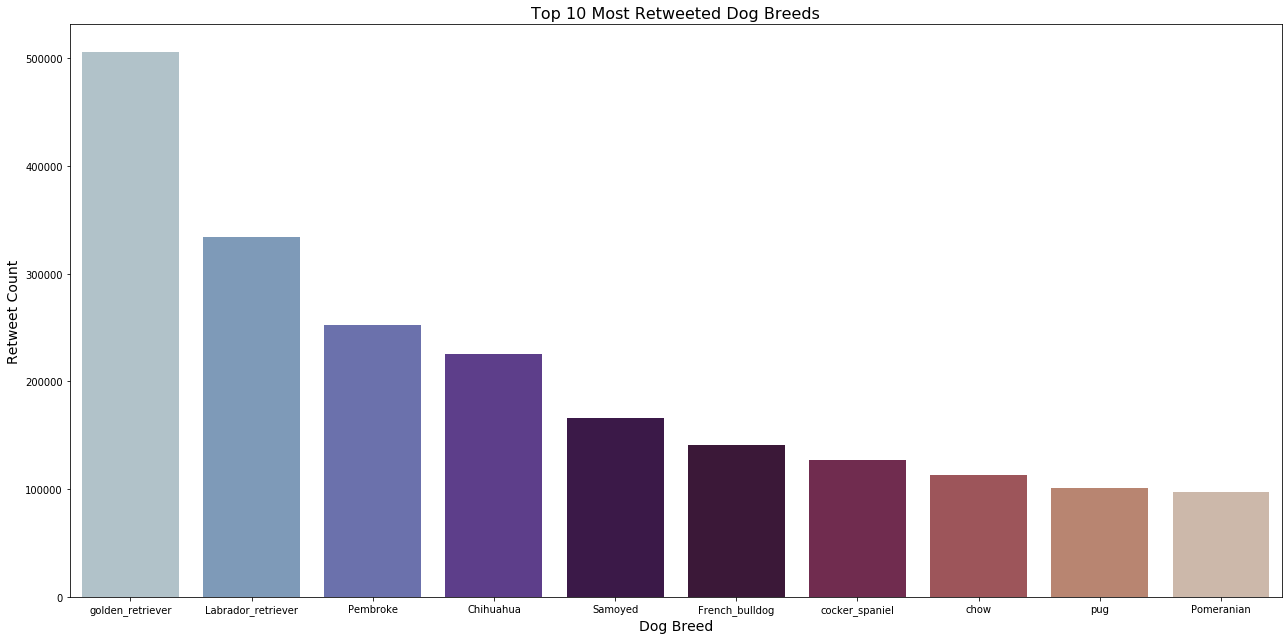

In [7]:
top10_retweeted_dog_breed = predicted_dog.groupby('breed')['retweet_count'].sum().sort_values(ascending = False).iloc[:10]
dog_breed = top10_retweeted_dog_breed.index
retweet_count = top10_retweeted_dog_breed.values
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.barplot(dog_breed, retweet_count, palette = "twilight")
ax.set_xlabel('Dog Breed', fontsize = 14)
ax.set_ylabel('Retweet Count', fontsize = 14)
ax.set_title('Top 10 Most Retweeted Dog Breeds', fontsize = 16)
plt.tight_layout()
plt.show()

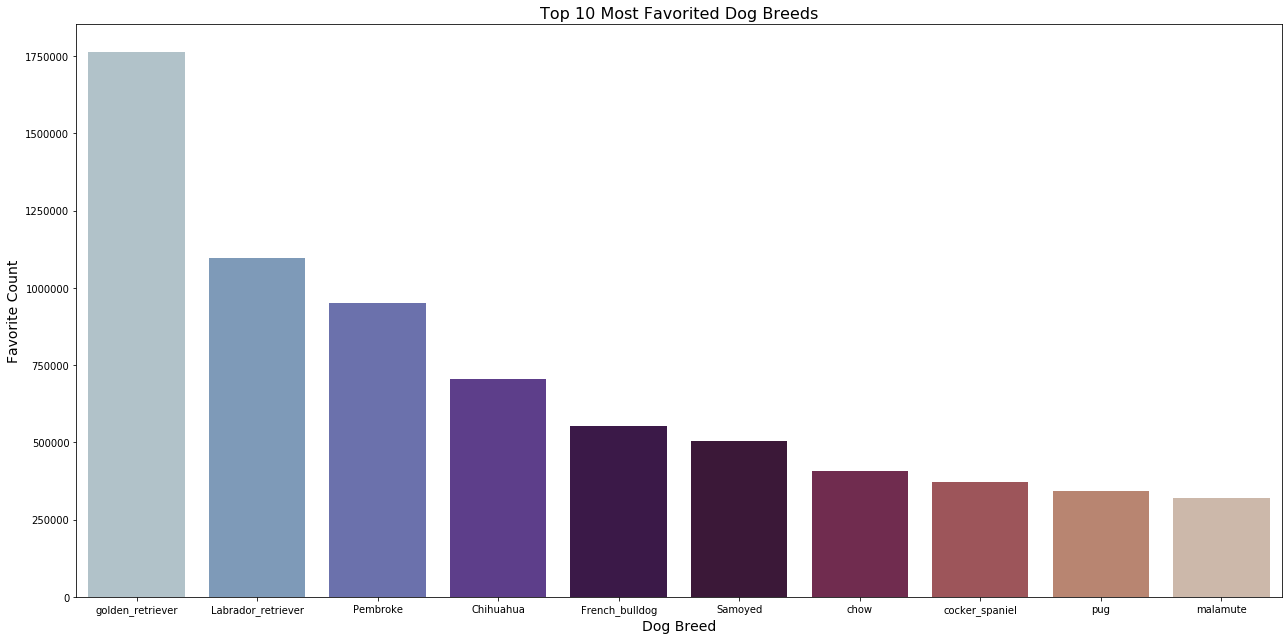

In [8]:
top10_favorited_dog_breed = predicted_dog.groupby('breed')['favorite_count'].sum().sort_values(ascending = False).iloc[:10]
dog_breed = top10_favorited_dog_breed.index
favorite_count = top10_favorited_dog_breed.values
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.barplot(dog_breed, favorite_count, palette = "twilight")
ax.set_xlabel('Dog Breed', fontsize = 14)
ax.set_ylabel('Favorite Count', fontsize = 14)
ax.set_title('Top 10 Most Favorited Dog Breeds', fontsize = 16)
plt.tight_layout()
plt.show()

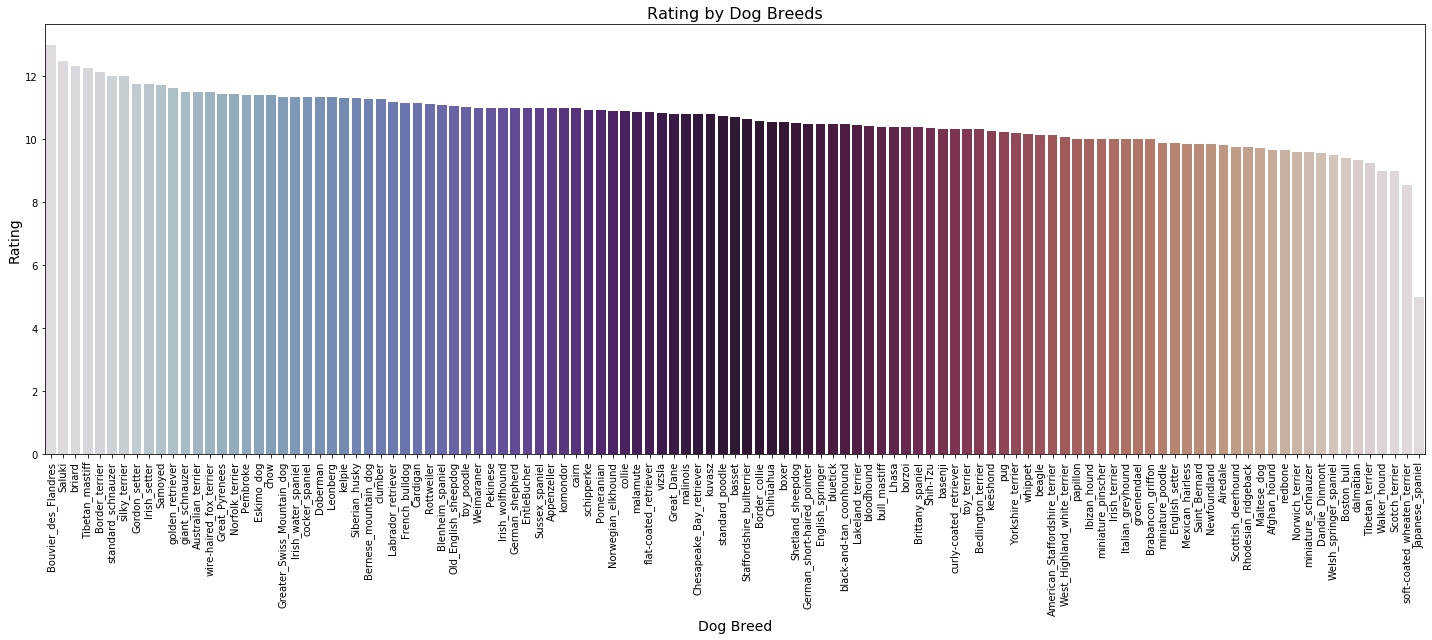

In [9]:
rating_dog_breed = predicted_dog.groupby('breed')['rating_numerator'].mean().sort_values(ascending = False)
dog_breed = rating_dog_breed.index
rating = rating_dog_breed.values
fig, ax = plt.subplots(figsize=(20,9))
ax = sns.barplot(dog_breed, rating, palette = "twilight")
ax.set_xticklabels(dog_breed, rotation=90)
ax.set_xlabel('Dog Breed', fontsize = 14)
ax.set_ylabel('Rating', fontsize = 14)
ax.set_title('Rating by Dog Breeds', fontsize = 16)
plt.tight_layout()
plt.show()

In [10]:
predicted_dog['rating_numerator'].describe()

count    1665.000000
mean       10.834102
std         1.778972
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

> The ratings are pretty uniform with a 25th percentile of 10, a 75th percentile of 12 and an average of 11. To find the most 'popular' dog breeds in WeRateDogs, I will only consider the dog breeds with an above average rating and compare them with the dog breeds from the `Top 10 Most Retweeted Dog Breeds` and `Top 10 Most Favorited Dog Breeds` list.

In [11]:
average_rating_dog_breed = predicted_dog.groupby('breed')['rating_numerator'].mean()
above_average_rating_dog_breed = average_rating_dog_breed[average_rating_dog_breed > 11]

In [12]:
a = top10_retweeted_dog_breed.index
b = top10_favorited_dog_breed.index
c = above_average_rating_dog_breed.index
popular_dogs = list(set(a) & set(b) & set(c))
popular_dogs

['French_bulldog',
 'Pembroke',
 'golden_retriever',
 'cocker_spaniel',
 'Samoyed',
 'chow',
 'Labrador_retriever']

> Here we have the last seven standing dog breeds, that have above average rating and are in the both `Top 10 Most Retweeted Dog Breeds` and `Top 10 Most Favorited Dog Breeds` list.

In [13]:
most_popular_dog_breeds = predicted_dog[predicted_dog['breed'].apply(lambda x: x in popular_dogs)]
most_popular_dog_breeds_agg = most_popular_dog_breeds.groupby('breed').agg({'tweet_id': 'count',
                                                                            'retweet_count': 'sum',
                                                                            'favorite_count': 'sum',
                                                                            'rating_numerator': 'mean'})

most_popular_dog_breeds_agg.columns = ['tweets', 'retweets', 'favorites', 'ratings']
most_popular_dog_breeds_agg.sort_values('tweets', ascending = False, inplace = True)
most_popular_dog_breeds_agg

,tweets,retweets,favorites,ratings
breed,,,,
golden_retriever,155,506150,1764555,11.622581
Labrador_retriever,102,334440,1095363,11.176471
Pembroke,95,252157,951201,11.410526
chow,47,113353,406792,11.404255
Samoyed,41,165887,506123,11.731707
French_bulldog,30,140679,552124,11.166667
cocker_spaniel,30,126662,371002,11.333333


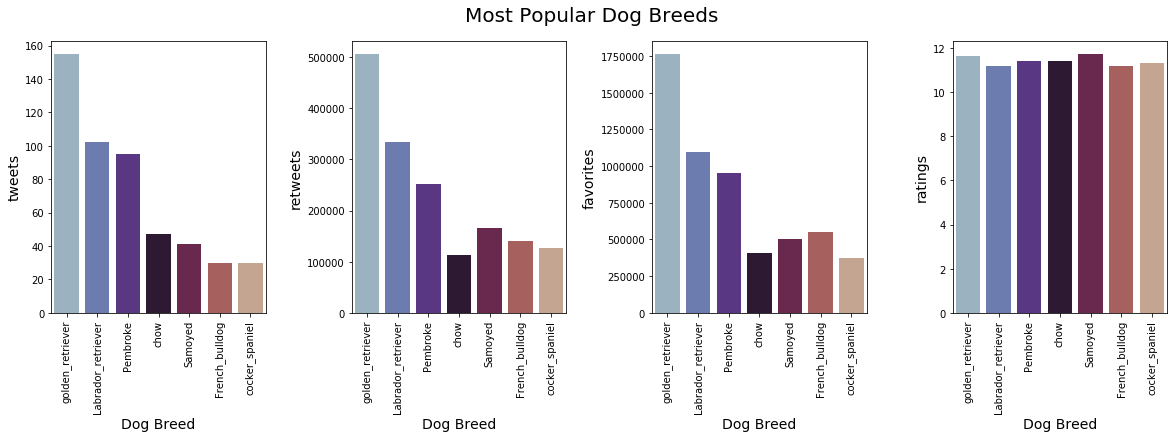

In [16]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.4)
i=1
for f in most_popular_dog_breeds_agg.columns:
    ax = fig.add_subplot(1, 4, i)
    ax = sns.barplot(x = most_popular_dog_breeds_agg.index, y = most_popular_dog_breeds_agg.loc[:, f], palette='twilight')
    ax.set_xlabel('Dog Breed', fontsize = 14)
    ax.set_xticklabels(most_popular_dog_breeds_agg.index, rotation=90)
    ax.set_ylabel(f, fontsize = 14)
    i+=1
fig.suptitle('Most Popular Dog Breeds', ha='center', va='center', fontsize=20, y=0.95);

> From the diagrams above we can see that all these dog breeds have very similar rating. However, `golden retriever` has significantly higher amount of tweets, retweets and favourites compared to other dog breeds. Second place goes to `labrador retriever`, followed by `pembroke`, which is in the third place in term of number of tweets, retweets and favorites. 

**3. How did WeRateDogs grow over the time?**

Compute the monthly total number of tweets as well as the total number of retweets and favorite of the tweets.

In [83]:
df = twitter_archive_master.copy()
df['year_month'] = df['timestamp'].dt.to_period('M')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [84]:
# Create a dataframe only consists of monthly total number of tweets, retweets and favorites
time_series = df.groupby('year_month').agg({'tweet_id': 'count',
                                            'retweet_count': 'sum',
                                            'favorite_count': 'sum'})

# Remove the last month due to lack of observations
time_series = time_series[:-1]

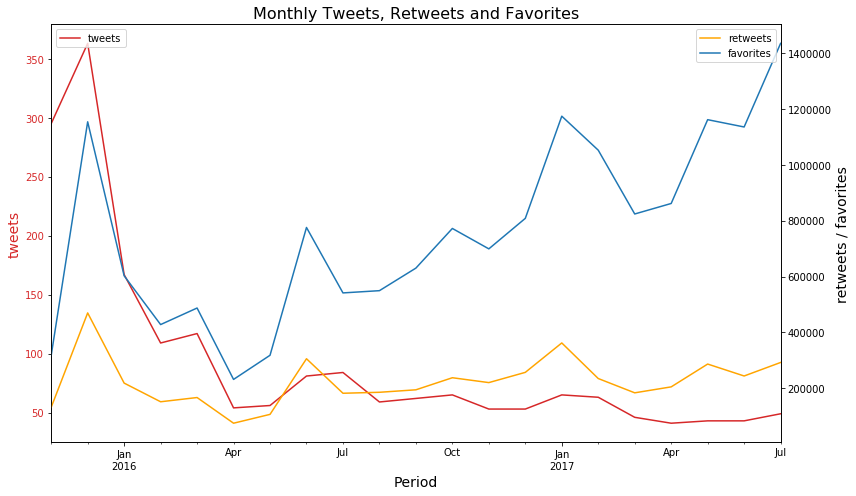

In [85]:
fig, ax = plt.subplots(figsize = (12, 7))
color = 'tab:red'
ax = time_series['tweet_id'].plot(color=color, label = 'tweets')
ax.set_xlabel('Period', fontsize = 14)
ax.set_ylabel('tweets', color = color, fontsize = 14)
ax.tick_params(axis='y', labelcolor=color)
ax.legend(loc='upper left')
ax.set_title("Monthly Tweets, Retweets and Favorites", fontsize = 16);

ax2 = ax.twinx()
ax2 = time_series['retweet_count'].plot(label = 'retweets', color = 'orange')
ax2 = time_series['favorite_count'].plot(label = 'favorites')
ax2.set_ylabel('retweets / favorites', fontsize = 14)
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()

> - The account was very active in the first two months when it was just started with more than 350 tweets in December 2015. However, there was a big decline in early 2016. The number of tweets per month was decreasing until it reached a relatively stable level with around 50-60 tweets per month. 
> - The number of retweets followed the similar trend as the number of tweets. It did not exhibit an obvious increase over a long period.
> - Interestingly, in contrast to the two variables above, the number of favorites showed an upward trend even though the number of tweets has stopped increasing since 2016 July.

**4. Are there any correlation between rating, retweets and favorites and dog stage?**

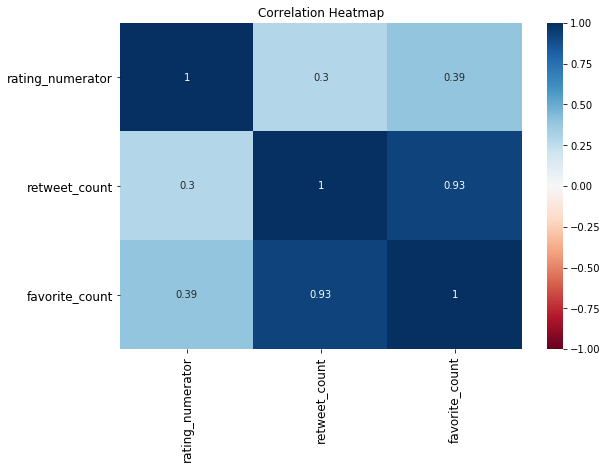

In [86]:
# Plot the correlations of quantitative variables using a heatmap
plt.figure(figsize = (9, 6))
s = sns.heatmap(twitter_archive_master[['rating_numerator', 'retweet_count', 'favorite_count']].corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

> - There is a very strong correlation between retweet and favorite count. 
> - The relationship between rating and favorite count is slight larger than the relationship between rating and retweet count.

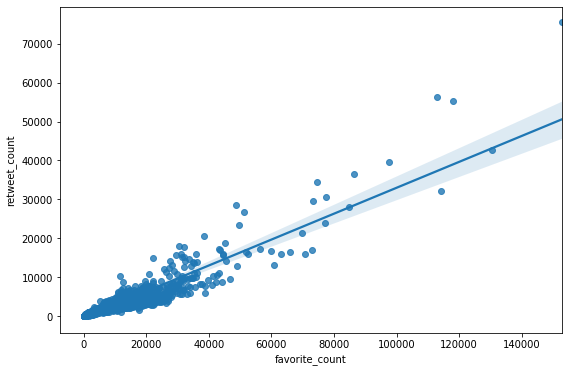

In [87]:
# Create regression plot
plt.figure(figsize = (9, 6))
sns.regplot(x=twitter_archive_master['favorite_count'], y=twitter_archive_master['retweet_count']);

> Again, This regression plot shows there is a linear relationship between retweet and favorite count.

### Linear regression models
- To predict retweet and favorite count based on rating
- To predict the rating based on dog stage

In [88]:
df_reg = twitter_archive_master.loc[:,['rating_numerator', 'retweet_count', 'favorite_count', 'dog_stage']]

**Predict retweet and favorite count based on rating**

In [89]:
# Rating - Favorites
df_reg['intercept'] = 1
y = df_reg['favorite_count']/1000
X = df_reg[['intercept', 'rating_numerator']]
lm = sm.OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     354.7
Date:                Wed, 04 Nov 2020   Prob (F-statistic):           7.13e-73
Time:                        23:51:44   Log-Likelihood:                -7524.2
No. Observations:                1970   AIC:                         1.505e+04
Df Residuals:                    1968   BIC:                         1.506e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept          -14.5014      1.227    -11.814      0.000     -16.909     -12.094
rating_numerator     2.1458      0.114     18.832      0.000       1.922       2.369
==============================================================================
Omnibus:                     1948.592   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120197.607
Skew:                           4.679   Prob(JB):                         0.00
Kurtosis:                      40.105   Cond. No.                         53.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> For every one unit increase in the rating, the number of favorite is predicted to increase by 2146.

In [90]:
# Rating - Retweets
y = df_reg['retweet_count']/1000
X = df_reg[['intercept', 'rating_numerator']]
lm = sm.OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     187.7
Date:                Wed, 04 Nov 2020   Prob (F-statistic):           7.08e-41
Time:                        23:51:44   Log-Likelihood:                -5576.6
No. Observations:                1970   AIC:                         1.116e+04
Df Residuals:                    1968   BIC:                         1.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -3.7287      0.457     -8.165      0.000      -4.624      -2.833
rating_numerator     0.5809      0.042     13.701      0.000       0.498       0.664
==============================================================================
Omnibus:                     2667.963   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           669087.510
Skew:                           7.523   Prob(JB):                         0.00
Kurtosis:                      92.022   Cond. No.                         53.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> For every one unit increase in the rating, the number of retweet is predicted to increase by 581.

**Predict the rating based on dog stage**

In [91]:
df_reg_partial = df_reg[~df_reg['dog_stage'].isnull()]
dummies = pd.get_dummies(df_reg_partial['dog_stage'])
df_reg_partial = df_reg_partial.join(dummies)
df_reg_partial['dog_stage'].value_counts()

pupper     205
doggo       63
puppo       24
floofer      7
Name: dog_stage, dtype: int64

In [92]:
# Dog Stage - Rating
df_reg_partial['intercept'] = 1
y = df_reg_partial['rating_numerator']
X = df_reg_partial[['intercept', 'pupper', 'puppo', 'doggo']]
lm = sm.OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       rating_numerator   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     10.79
Date:                Wed, 04 Nov 2020   Prob (F-statistic):           9.52e-07
Time:                        23:51:44   Log-Likelihood:                -577.99
No. Observations:                 299   AIC:                             1164.
Df Residuals:                     295   BIC:                             1179.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.0000      0.636     18.859      0.000      10.748      13.252
pupper        -1.3450      0.647     -2.079      0.039      -2.619      -0.072
puppo        2.22e-16      0.723   3.07e-16      1.000      -1.423       1.423
doggo         -0.2381      0.671     -0.355      0.723      -1.558       1.082
==============================================================================
Omnibus:                       51.739   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.576
Skew:                          -0.944   Prob(JB):                     4.79e-21
Kurtosis:                       4.986   Cond. No.                         16.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Based on the results, a pupper is predicted to be less rated by 1.35 compared to a floofer, holding other variables constant, and p-value associated is statistically significant. However, this prediction is not really convincing because this categorical variable is imbalance, by having much more pupper than floofer in this dataset.

In [94]:
# Generate .html file in the workspace directory 
from subprocess import call
call(['python', '-m', 'nbconvert', 'wrangle_act.ipynb'])

0